# Mistaken Mice notebook

2020 NMA academy project, mistaken mice group, pod 173 antique cicada

# Import packages and functions

In [8]:
# to import the functions we wrote, clone the git repo
#!git clone https://github.com/jorgeerrz/mistaken_mice.git
#%cd mistaken_mice
#alternatively, run the notebook locally, then just comment the lines above

from filter import *
from summarise_dataset import *
from PCA_fun import neurons_PCA
from GLM import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading of Steinmetz data

In [9]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)


In [10]:
# skip if you already downloaded the data
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [11]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


# Filter the data

In [12]:
# need to loop over all sessions to pass as input to summarise_data function in next step
first_session_filtered_VISp = filter_spikes(alldat,0,'VISp') 
first_session_filtered = filter_spikes(alldat,0) 
print(np.shape(first_session_filtered['spks']))

(734, 10, 250)


# Summarise the filtered data

{'n_neurons': array([ 734., 1070.,  619., 1769., 1077., 1169.,  584., 1156.,  788.,
        1172.,  857.,  698.,  983.,  756.,  743.,  474.,  565., 1089.,
         606.,  899.,  578.,  646., 1268., 1337.,  885., 1056.,  563.,
         549.,  750.,  942.,  977.,  522.,  613.,  781.,  795.,  680.,
        1055.,  805., 1348.]),
 'n_trials': array([214., 251., 228., 249., 254., 290., 252., 250., 372., 447., 342.,
        340., 300., 268., 404., 280., 224., 316., 247., 235., 124., 444.,
        151., 187., 261., 178., 253., 142., 128., 143., 237., 260., 191.,
        296., 311., 258., 181., 199., 343.]),
 'n_timebins': array([250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250.])}

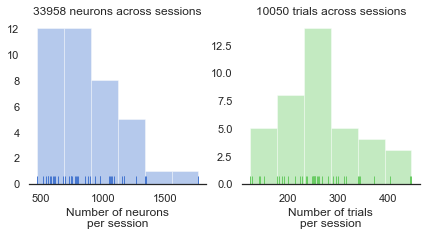

In [13]:
summarise_dataset(alldat) # should be filtered data, but alldat is used here as an example


# Change the time bin
Optional step

In [14]:
dat = first_session_filtered
NT = dat['spks'].shape[-1]
minT = 50
maxT = 130
NN = dat['spks'].shape[0]

droll = np.reshape(dat['spks'][:,:,minT:maxT], (NN,-1))

dat['spks'][:,:,minT:maxT].mean(axis=2).shape


(734, 10)

# Filter, PCA, and Model one session

Number of PCs: 11
Accuracies: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
Mean Accuracy: 0.875
Predictions: [-1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.
  1.  1. -1.  1.  1.  1.]
Actual: [ 1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.
  1. -1. -1.  1.  1.  1.]
Probs: [0.5564369705682841, 0.8570853485788563, 0.8441476466264013, 0.7676050716832965, 0.8225547253981749, 0.6659382741118465, 0.6207706036482168, 0.7266684217024195, 0.6804171377728084, 0.8259298198114515, 0.5706316660996401, 0.5707157423270288, 0.6170222448171019, 0.669661110850001, 0.7408411848009882, 0.5898365356020686, 0.8074129831818202, 0.816356477232268, 0.6062753395249428, 0.582884735742918, 0.8049926395283105, 0.6661736548987448, 0.7538935005576495, 0.6829938795836185]
Percent Left: 0.5833333333333334
Percent Right: 0.4166666666666667


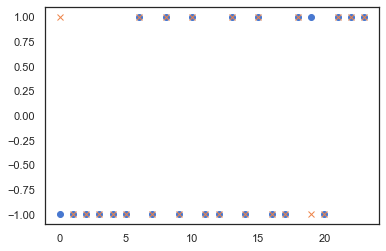

In [208]:
from sklearn.model_selection import *

session = 10
brain_areas = ["MOp"]


filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
dat = neurons_PCA(filtered,0.9,0,250,toplot=False)
#dat['PCs'] = dat['PCs'][0:dat['PCrange'],:]
lambda_L2 = 1
penalty = "l2"
l1args = {}
logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
splitter = LeaveOneOut()
splits = splitter.split(dat['PCs'].T)
accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=0) # k=8 crossvalidation
logreg.fit(dat['PCs'].T, filtered['chcs'])
predictions = logreg.predict(dat['PCs'].T)

probs = logreg.predict_proba(dat['PCs'].T)
mprobs = [max(prob) for prob in probs]

print('Number of PCs: '+str(dat['PCrange']))

print('Accuracies: '+str(accuracies))
print('Mean Accuracy: '+str(np.mean(accuracies)))
print('Predictions: '+ str(predictions))
print('Actual: '+ str(filtered['chcs']))
print('Probs: '+ str(mprobs))

print('Percent Left: ' +str(np.mean((filtered['chcs'])==-1)))
print('Percent Right: ' +str(np.mean((filtered['chcs'])==1)))

plt.plot(predictions,linewidth=0,marker='o')
plt.plot(filtered['chcs'],linewidth=0,marker='x')


# Filter, PCA, and Model all sessions (with neurons)

In [192]:
brain_areas = ['MOp']
for session in range(len(alldat)):
    if np.sum(np.isin(alldat[session]['brain_area'],brain_areas))>0:
        filtered = filter_spikes(alldat,session,unfair_only=True,chosey_only=True, nonzero_only=True,brain_area=brain_areas)
        dat = neurons_PCA(filtered,0.9,0,250)
       # dat['PCs'] = dat['PCs'][0:dat['PCrange'],:]
        lambda_L2 = 1
        penalty = "none"
        l1args = {}
       # l1args = {'solver':"saga", 'max_iter':5000}
        logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
        splitter = LeaveOneOut()
        splits = splitter.split(dat['PCs'].T)
        accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=0) # k=8 crossvalidation
        left_bias = np.mean((filtered['chcs'])==-1)
        choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
        aob = accuracies.mean() - choice_bias
        print("Session# "+ str(session)+" accuracy over bias = "+str(accuracies.mean() - choice_bias) + ", trial count= "+ str(len(accuracies)),"PC count= "+ str(dat['PCs'].shape[0]))

Session# 10 accuracy over bias = [0.33333333], trial count= 24 PC count= 24
Session# 20 accuracy over bias = [-0.14285714], trial count= 7 PC count= 7
Session# 28 accuracy over bias = [0.22222222], trial count= 9 PC count= 9


# Filter, PCA, and Model w/ different time bins

In [136]:
binl = 25
bins = [x for x in range(0,250,binl)]
brain_areas = ["MOp"]

for bin in bins:
    session = 10
    filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
    dat = neurons_PCA(filtered,0.9,bin,bin+binl)
    lambda_L2 = 1
    penalty = "l2"
    l1args = {}
    logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
    splitter = LeaveOneOut()
    splits = splitter.split(dat['PCs'].T)
    accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=0) # k=8 crossvalidation
    print("Bin "+str(bin)+" to "+str(bin+binl)+" accuracy mean= "+str(accuracies.mean())+ ", percent left "+ str(np.mean((filtered['chcs'])==-1)))

ValueError: zero-size array to reduction operation maximum which has no identity

In [126]:
[(session,np.sum(np.isin(alldat[session]['brain_area'],["VISam", "VISl", "VISp", "VISpm", "VISrl"])), np.sum(np.isin(alldat[session]['brain_area'],["ACB","CP"]))) for session in range(len(alldat))]

[(0, 178, 0),
 (1, 533, 0),
 (2, 228, 0),
 (3, 39, 0),
 (4, 0, 0),
 (5, 0, 0),
 (6, 0, 59),
 (7, 48, 0),
 (8, 142, 0),
 (9, 340, 0),
 (10, 0, 275),
 (11, 145, 0),
 (12, 34, 0),
 (13, 42, 0),
 (14, 0, 0),
 (15, 0, 0),
 (16, 0, 0),
 (17, 0, 313),
 (18, 179, 0),
 (19, 122, 0),
 (20, 0, 0),
 (21, 133, 92),
 (22, 190, 0),
 (23, 296, 0),
 (24, 94, 0),
 (25, 162, 0),
 (26, 103, 90),
 (27, 71, 0),
 (28, 0, 340),
 (29, 0, 0),
 (30, 0, 0),
 (31, 0, 0),
 (32, 0, 383),
 (33, 0, 0),
 (34, 75, 0),
 (35, 53, 0),
 (36, 77, 0),
 (37, 0, 0),
 (38, 141, 0)]

In [123]:
aba = []
for session in alldat:
    for ba in session['brain_area']:
        if ba not in aba:
            aba.append(ba)
            
print(np.sort(aba))

['ACA' 'ACB' 'APN' 'AUD' 'BLA' 'BMA' 'CA' 'CA1' 'CA2' 'CA3' 'CL' 'COA'
 'CP' 'DG' 'DP' 'EP' 'EPd' 'GPe' 'IC' 'ILA' 'LD' 'LGd' 'LH' 'LP' 'LS'
 'LSc' 'LSr' 'MB' 'MD' 'MEA' 'MG' 'MOp' 'MOs' 'MRN' 'MS' 'NB' 'OLF' 'ORB'
 'ORBm' 'OT' 'PAG' 'PIR' 'PL' 'PO' 'POL' 'POST' 'PT' 'RN' 'RSP' 'RT'
 'SCig' 'SCm' 'SCs' 'SCsg' 'SI' 'SNr' 'SPF' 'SSp' 'SSs' 'SUB' 'TH' 'TT'
 'VAL' 'VISa' 'VISam' 'VISl' 'VISp' 'VISpm' 'VISrl' 'VPL' 'VPM' 'ZI'
 'root']


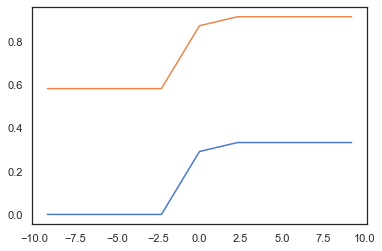

In [180]:
lams = np.logspace(-4,4,num=9)
aobs = []
accs = []
for lam in lams:
    session = 10
    filtered = filter_spikes(alldat,session,unfair_only=True,chosey_only=True, nonzero_only=True,brain_area=brain_areas)
    dat = neurons_PCA(filtered,0.9,0,250)
    lambda_L2 = lam
    penalty = "l2"
    l1args = {}
    logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
    splitter = LeaveOneOut()
    splits = splitter.split(dat['PCs'].T)
    accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=0) # k=8 crossvalidation
    left_bias = np.mean((filtered['chcs'])==-1)
    choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
    aob = accuracies.mean() - choice_bias
    aobs.append(aob)
    accs.append(accuracies.mean())
plt.plot(np.log(lams),aobs)
plt.plot(np.log(lams),accs)